In [27]:
# automatically update changes from other module
%load_ext autoreload
%autoreload 2

import sys
import os
# ".." means "go up one level to the parent directory"
sys.path.append(os.path.abspath(".."))
import processing_data as pr



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import pandas as pd
from pandas.io.parquet import to_parquet
import numpy as np
import matplotlib.pyplot as plt
import glob

In [29]:
folder_path = r"C:\Users\ADMIN\Documents\Quantitative\universe\stocks_data\*.csv"
all_files = glob.glob(folder_path)
print(f"found {len(all_files)} stock files")

found 998 stock files


In [30]:
def process_single_stock(csv_path):
    try:
        df = pr.load_data(csv_path)
        df = pr.sort_and_deduplicate(df)
        df = pr.adjust_for_splits_and_dividends(df)
        return df
    
    except Exception as e:
        print(f"Error processing {csv_path}: {e}")
        return None


In [31]:
all_files[:5]

['C:\\Users\\ADMIN\\Documents\\Quantitative\\universe\\stocks_data\\stock_A.csv',
 'C:\\Users\\ADMIN\\Documents\\Quantitative\\universe\\stocks_data\\stock_AA.csv',
 'C:\\Users\\ADMIN\\Documents\\Quantitative\\universe\\stocks_data\\stock_AAL.csv',
 'C:\\Users\\ADMIN\\Documents\\Quantitative\\universe\\stocks_data\\stock_AAON.csv',
 'C:\\Users\\ADMIN\\Documents\\Quantitative\\universe\\stocks_data\\stock_AAPL.csv']

In [32]:
processed_data = []

for i, csv_path in enumerate(all_files):
    df_stock = process_single_stock(csv_path)

    if df_stock is not None:
        processed_data.append(df_stock)
    
    if (i+1) % 100 == 0:
        print(f"process {i+1}/{len(all_files)} files")

if processed_data:
    df_final = pd.concat(processed_data, ignore_index=True)
    print(f"Successfully loaded {df_final['ticker'].nunique()} tickers.")
    print(f"Total rows: {len(df_final)}")
else:
    print("No data loaded!")

df_final.head()

# save as parquet file
# df_final.to_parquet("all_stocks_cleaned.parquet")


process 100/998 files
process 200/998 files
process 300/998 files
process 400/998 files
process 500/998 files
process 600/998 files
process 700/998 files
process 800/998 files
process 900/998 files
Successfully loaded 994 tickers.
Total rows: 2336125


,date,ticker,adj_close,close,high,low,open,volume
0,2015-01-02,A,37.120953,37.120953,37.807361,36.947060,37.688382,1.670872e+06
1,2015-01-05,A,36.425388,36.425388,37.029427,36.333869,36.901298,2.230961e+06
2,2015-01-06,A,35.857956,35.857956,36.626733,35.711522,36.434540,2.273356e+06
3,2015-01-07,A,36.333870,36.333870,36.434544,35.958634,36.169132,3.670958e+06
4,2015-01-08,A,37.422955,37.422955,37.505324,36.773156,36.828070,2.312364e+06


In [33]:
def resample_n_months(data, m):
    """
    Resamples daily data to M-Month end data.
    """
    # Ensure index is set for resampling
    if "date" in data.columns:
        data = data.set_index("date")
        
    agg_dict = {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum"
    }

    # Resample
    data_resampled = (
         data.groupby("ticker")
        .resample(f"{m}ME")
        .agg(agg_dict)
        .reset_index()
    )
    return data_resampled

In [34]:
def calculate_log_return(data):
    # We use 'close' here because it is already split-adjusted
    data["log_return"] = (
        np.log(data["close"]) - 
        np.log(data.groupby("ticker")["close"].shift(1))
    )

    data = data.dropna(subset=["log_return"]).copy()
    data["lagged_return"] = data.groupby("ticker")["log_return"].shift(1)
    return data

In [35]:
def generate_signals(data, n_long, n_short):
    """
    Long top n_long stocks, Short bottom n_short stocks based on lagged return.
    """
    # Rank stocks by return (Descending: High return = Rank 1)
    data["rank"] = data.groupby("date")["lagged_return"].rank(method="first", ascending=False)
    
    # Calculate max rank per date to find bottom stocks
    data["max_rank"] = data.groupby("date")["rank"].transform("max")
    
    data["position"] = 0
    
    # Long Top N
    data.loc[data["rank"] <= n_long, "position"] = 1
    
    # Short Bottom N
    data.loc[data["rank"] > (data["max_rank"] - n_short), "position"] = -1
    
    return data

In [36]:
def backtest(data):
    # Weight = 1 / Count (Equal Weighting)
    # We calculate counts separately for Longs (1) and Shorts (-1)
    
    # Helper to calculate weight per group
    def assign_weight(group):
        if group.name == 0: return 0 # No position
        return 1 / len(group)

    data["weight"] = data.groupby(["date", "position"])["position"].transform(lambda x: 1/len(x) if x.iloc[0] != 0 else 0)
    
    data["weighted_return"] = data["log_return"] * data["weight"]
    
    # Compute portfolio return
    # This pivots the table so we have columns for Position -1 and Position 1
    port_returns = (
        data[data["position"] != 0]
        .groupby(["date", "position"])["weighted_return"]
        .sum()
        .unstack(fill_value=0)
    )
    
    # Ensure we have both sides (handle cases where maybe only longs existed)
    if -1 not in port_returns.columns: port_returns[-1] = 0
    if 1 not in port_returns.columns: port_returns[1] = 0
    
    # Total Return = Long Side - Short Side (Since shorting positive return is a loss)
    # Note: Standard convention for log returns is just sum, but for PnL:
    # Long PnL + Short PnL. 
    # If weighted_return for short is negative (price down), we make money.
    # So we subtract the short return vector.
    port_returns["total"] = port_returns[1] - port_returns[-1]
    
    # Cumulative
    port_returns["cum_return"] = port_returns["total"].cumsum().apply(np.exp)
    
    return port_returns

In [37]:
def calculate_metrics(df_result, risk_free_rate=0.0, periods_per_year=12):
    """
    df_result: The dataframe returned by your backtest() function
    periods_per_year: 12 for Monthly, 252 for Daily
    """
    # 1. Get the period returns (Long - Short)
    # In your code this was column "total"
    returns = df_result["total"]
    
    # --- Annualized Return ---
    # We essentially project the average monthly return to a year
    mean_return_period = returns.mean()
    ann_return = mean_return_period * periods_per_year
    
    # --- Annualized Volatility ---
    # Standard Deviation * Sqrt(N)
    std_dev_period = returns.std()
    ann_volatility = std_dev_period * np.sqrt(periods_per_year)
    
    # --- Sharpe Ratio ---
    # (Return - RiskFree) / Volatility
    if ann_volatility > 0:
        sharpe_ratio = (ann_return - risk_free_rate) / ann_volatility
    else:
        sharpe_ratio = 0.0
        
    # --- Max Drawdown ---
    # Drawdown = (Current Wealth / Previous Peak Wealth) - 1
    wealth_index = df_result["cum_return"]
    previous_peaks = wealth_index.cummax()
    drawdown = (wealth_index - previous_peaks) / previous_peaks
    max_drawdown = drawdown.min()
    
    # Return as a Pandas Series for nice printing
    metrics = pd.Series({
        "Annualized Return": f"{ann_return:.2%}",
        "Annualized Volatility": f"{ann_volatility:.2%}",
        "Sharpe Ratio": f"{sharpe_ratio:.2f}",
        "Max Drawdown": f"{max_drawdown:.2%}"
    })
    
    return metrics

Running backtest for 1-month holding period...
Running backtest for 3-month holding period...
Running backtest for 6-month holding period...
Running backtest for 12-month holding period...


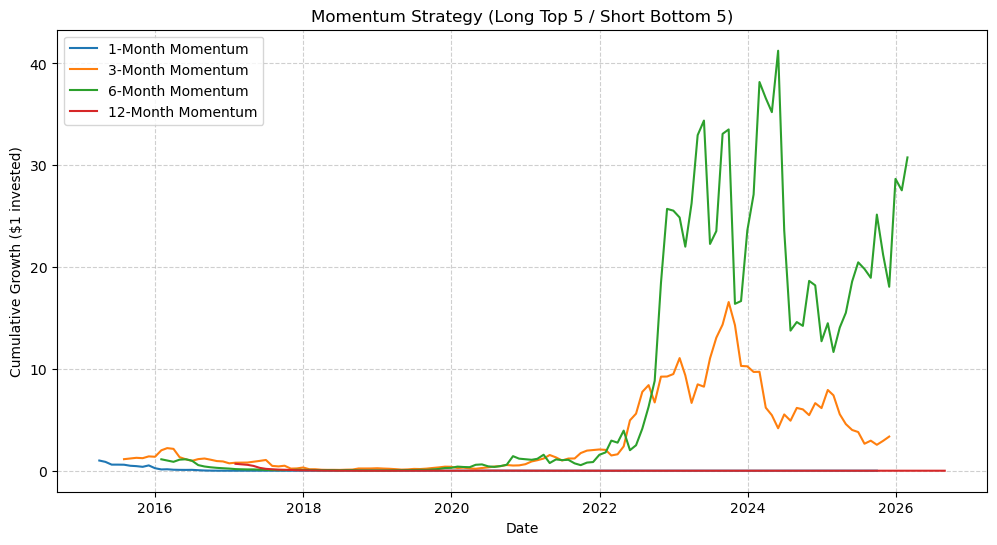

In [38]:
# --- Parameters ---
holding_periods = [1, 3, 6, 12]  # Months
n_stocks_long = 5
n_stocks_short = 5

plt.figure(figsize=(12, 6))

for m in holding_periods:
    print(f"Running backtest for {m}-month holding period...")
    
    # 1. Resample clean data
    df_m = resample_n_months(df_final, m)
    
    # 2. Features
    df_m = calculate_log_return(df_m)
    
    # 3. Signals
    df_m = generate_signals(df_m, n_stocks_long, n_stocks_short)
    
    # 4. Backtest
    res = backtest(df_m)
    
    # 5. Plot
    plt.plot(res.index, res["cum_return"], label=f"{m}-Month Momentum")

plt.title(f"Momentum Strategy (Long Top {n_stocks_long} / Short Bottom {n_stocks_short})")
plt.xlabel("Date")
plt.ylabel("Cumulative Growth ($1 invested)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()